# <center>Analysis of Mass Spectroscopy</center> #

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pdb
from scipy import stats

In [2]:
# constants for plots
fs = 16
lw = 2
ms = 4

In [3]:
df = pd.read_excel('4bromo.xlsx', sheet_name='Sheet1')
df = df.drop(df.loc[:, df.columns.str.contains('Unnamed')], axis = 1)

** The abundance is normalized by the second highest peak **

In [4]:
#The abundance values will be normalized by the second highest peak.
for ci in range(int(len(df.columns)/2)):
    mysort = np.sort(df.iloc[:, 2*ci+1].dropna())
    df.iloc[:, 2*ci+1] /= float(mysort[-2])

## Select data ##

In [5]:
def select_df(df, time, chiral_type, cri = 0):
    '''This function put together the average abundance, std, etc.The inputs are 
    time and chiralality of the molecule.
    cri is the criterion used for selection. Values below cri will be discarded.
    Returns a 2-column numpy array.
    
    Since the peak time for each test varies from one another, a dictionary is 
    built to store the peaks produced at same time. Then loop over the keys
    in the dictionary to obtain the mean and std, etc.
    This is function is quite slow though, and was replaced by the select_df_pd().
    '''
    df_temp = df.loc[:, df.columns.str.contains(time)]
    df_type = df_temp.loc[:, df_temp.columns.str.contains(chiral_type)]
    temp = {}
    for ai in range(len(df_type.index)):
        for ci in range(int(len(df_type.columns)/2)):
            if np.isnan(df_type.iloc[ai, 2*ci]) or df_type.iloc[ai, 2*ci+1] < cri:
                continue
            elif not df_type.iloc[ai, 2*ci] in temp:
                temp[df_type.iloc[ai, 2*ci]] = [df_type.iloc[ai, 2*ci+1]]
            else:
                temp[df_type.iloc[ai, 2*ci]].append(df_type.iloc[ai, 2*ci+1])
    mylist = []
    for key in temp.keys():
        mylist.append([key, np.mean(temp[key]), np.std(temp[key])])
    mylist = np.array(mylist)
    return mylist[mylist[:, 0].argsort()]

In [6]:
def select_df_pd(df, time, chiral_type):
    '''Use pandas DataFrame's function concat() to combine data, this makes 
    this function much faster than the previous function select_df(), because
    the index is automatically matched when concatenate two data frames'''
    df_temp = df.loc[:, df.columns.str.contains(time)]
    df_type = df_temp.loc[:, df_temp.columns.str.contains(chiral_type)]
    ans = pd.DataFrame()
    for ci in range(int(len(df_type.columns)/2)):
        temp = pd.DataFrame(df_type.iloc[:, 2*ci+1].values, index = df_type.iloc[:, 2*ci].values, columns = [str(ci)])
        temp = temp.dropna(axis = 0)
        ans = pd.concat([ans, temp], axis = 1, join = 'outer')
    ans['avg'] = ans.mean(axis = 1, skipna = True)
    ans['std'] = ans.iloc[:, :-1].std(axis = 1, skipna = True)
    ans['cnt'] = ans.iloc[:, :-2].count(axis = 1, numeric_only = True)
    return ans[['avg', 'std', 'cnt']]

In [35]:
def plot_twin_bar(s, r, width = 0.5, title = 'Standard deviation at 7.7 min', 
                 xlabel = 'Mass', ylabel = 'Normalized abundance'):
    '''This is a function that plots 2 bar plots, where the second one is ploted 
    upside down to compare with the first plot with the same x-axis.
    s and r are tuples that contain (index, values)
    '''
    fig, axes = plt.subplots(2, figsize = (8, 3), dpi = 300, sharex = True)
    axes[0].set_title(title)
    axes[0].bar(s[0], s[1], width, color = 'b', alpha = 0.5, label = 'S')
    axes[1].bar(r[0], r[1], width, color = 'r', alpha = 0.5, label = 'R')
    axes[0].set_ylabel(ylabel, ha = 'center')
    axes[0].yaxis.set_label_coords(-0.05, 0)
    axes[0].legend(loc = 'upper right')
    axes[1].legend(loc = 'lower right')
    axes[1].set_xlabel(xlabel)
    for ax in axes:
        ax.set_ylim([0, 2])
        ax.tick_params(direction = 'in')
        ax.grid(ls = ':', c = 'gray')
    axes[1].invert_yaxis()
    plt.subplots_adjust(wspace=0, hspace=0)

In [36]:
def plot_twin_error(s, r, title = 'Averaged abundance with errorbars at 7.7 min', 
                    xlabel = 'Mass', ylabel = 'Normalized abundance'):
    '''Plot S and R with errorbars
    s and r are data frame that has the columns 'avg' and 'std'.
    '''
    fig, axes = plt.subplots(2, figsize = (8, 3), dpi = 300, sharex = True)
    axes[0].set_title(title)
    axes[0].errorbar(s.index, s['avg'], yerr = s['std'], fmt = 's', alpha = 0.5, color = 'b', label = 'S', ms = ms, capsize = 2)
    axes[1].errorbar(r.index, r['avg'], yerr = r['std'], fmt = 'o', alpha = 0.5, color = 'r', label = 'R', ms = ms, capsize = 2)
    axes[0].set_ylabel(ylabel, ha = 'center')
    axes[0].yaxis.set_label_coords(-0.05, 0)
    axes[0].legend(loc = 'upper right')
    axes[1].legend(loc = 'lower right')
    axes[1].set_xlabel(xlabel)
    for ax in axes:
        ax.set_ylim([0, 1.5])
        ax.tick_params(direction = 'in')
        ax.grid(ls = ':', c = 'gray')
    axes[1].invert_yaxis()
    axes[0].set_xticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)

** We are only intertested at the major peak at 7.7 min in the mass spectroscopy plots**

In [9]:
df_s_77 = select_df_pd(df, '7.7', 'S').sort_values('avg', ascending = False).iloc[:100].sort_index()
df_r_77 = select_df_pd(df, '7.7', 'R').sort_values('avg', ascending = False).iloc[:100].sort_index()

In [10]:
df_s_77

,avg,std,cnt
15.20,0.131196,0.030254,12
15.25,0.144450,0.019027,6
18.15,0.165543,NaN,1
18.20,0.180048,0.050985,16
18.25,0.169928,NaN,1
27.15,0.188047,NaN,1
27.20,0.160526,0.025928,17
28.15,0.147974,0.035020,9
28.20,0.177095,0.049772,9
29.10,0.206023,NaN,1


** Notice that some of the masses only has 1 data point, which makes the std NaN **

Here we just drop those data, because they will be statistically insignificant anyway.

In [11]:
df_s_77.dropna(how = 'any', inplace = True)
df_r_77.dropna(how = 'any', inplace = True)

** Showing the top 10 most frequent peaks in the compound S **

In [12]:
df_s_77.sort_values('cnt', ascending = False).iloc[:10]

,avg,std,cnt
77.10,1.402274,0.110616,18
78.10,0.682931,0.056332,18
27.20,0.160526,0.025928,17
75.10,0.265398,0.015805,16
18.20,0.180048,0.050985,16
121.10,0.261737,0.022579,16
154.95,0.092995,0.008125,15
202.00,0.237943,0.018766,15
104.10,0.115502,0.012970,14
182.95,0.092979,0.010890,14


** Showing the top 10 highest peaks in the compound S **

In [13]:
df_s_77.sort_values('avg', ascending = False).iloc[:10]

,avg,std,cnt
77.10,1.402274,0.110616,18
184.95,0.992760,0.012146,12
185.00,0.955552,0.108876,6
43.10,0.948175,0.040483,8
43.15,0.943019,0.113568,9
186.95,0.890129,0.022331,9
187.00,0.863258,0.088165,8
78.10,0.682931,0.056332,18
51.15,0.472321,0.013217,10
51.10,0.462732,0.060627,8


** Showing the top 10 most frequent peaks in the compound R **

In [14]:
df_r_77.sort_values('cnt', ascending = False).iloc[:10]

,avg,std,cnt
78.10,0.664951,0.031808,18
77.10,1.382453,0.059097,18
18.20,0.214591,0.035335,17
75.10,0.261942,0.018808,17
38.15,0.095061,0.006884,16
76.10,0.221196,0.013860,15
27.20,0.164152,0.015678,15
39.15,0.179360,0.009593,15
41.15,0.077051,0.011414,15
121.10,0.267450,0.012977,14


** Showing the top 10 highest peaks in the compound R **

In [15]:
df_r_77.sort_values('avg', ascending = False).iloc[:10]

,avg,std,cnt
77.10,1.382453,0.059097,18
184.95,0.987042,0.023503,6
185.00,0.983286,0.023653,11
43.10,0.983170,0.032715,5
43.15,0.971210,0.034224,12
186.95,0.856760,0.034297,7
187.00,0.850746,0.028885,11
78.10,0.664951,0.031808,18
51.10,0.471852,0.026120,6
51.15,0.463560,0.025306,12


In [16]:
df_s_77

,avg,std,cnt
15.20,0.131196,0.030254,12
15.25,0.144450,0.019027,6
18.20,0.180048,0.050985,16
27.20,0.160526,0.025928,17
28.15,0.147974,0.035020,9
28.20,0.177095,0.049772,9
29.15,0.181356,0.021600,6
29.20,0.172149,0.024770,11
38.10,0.087872,0.016473,4
38.15,0.094377,0.004198,11


** Plot the averaged abundance of S and R at 7.7 min **

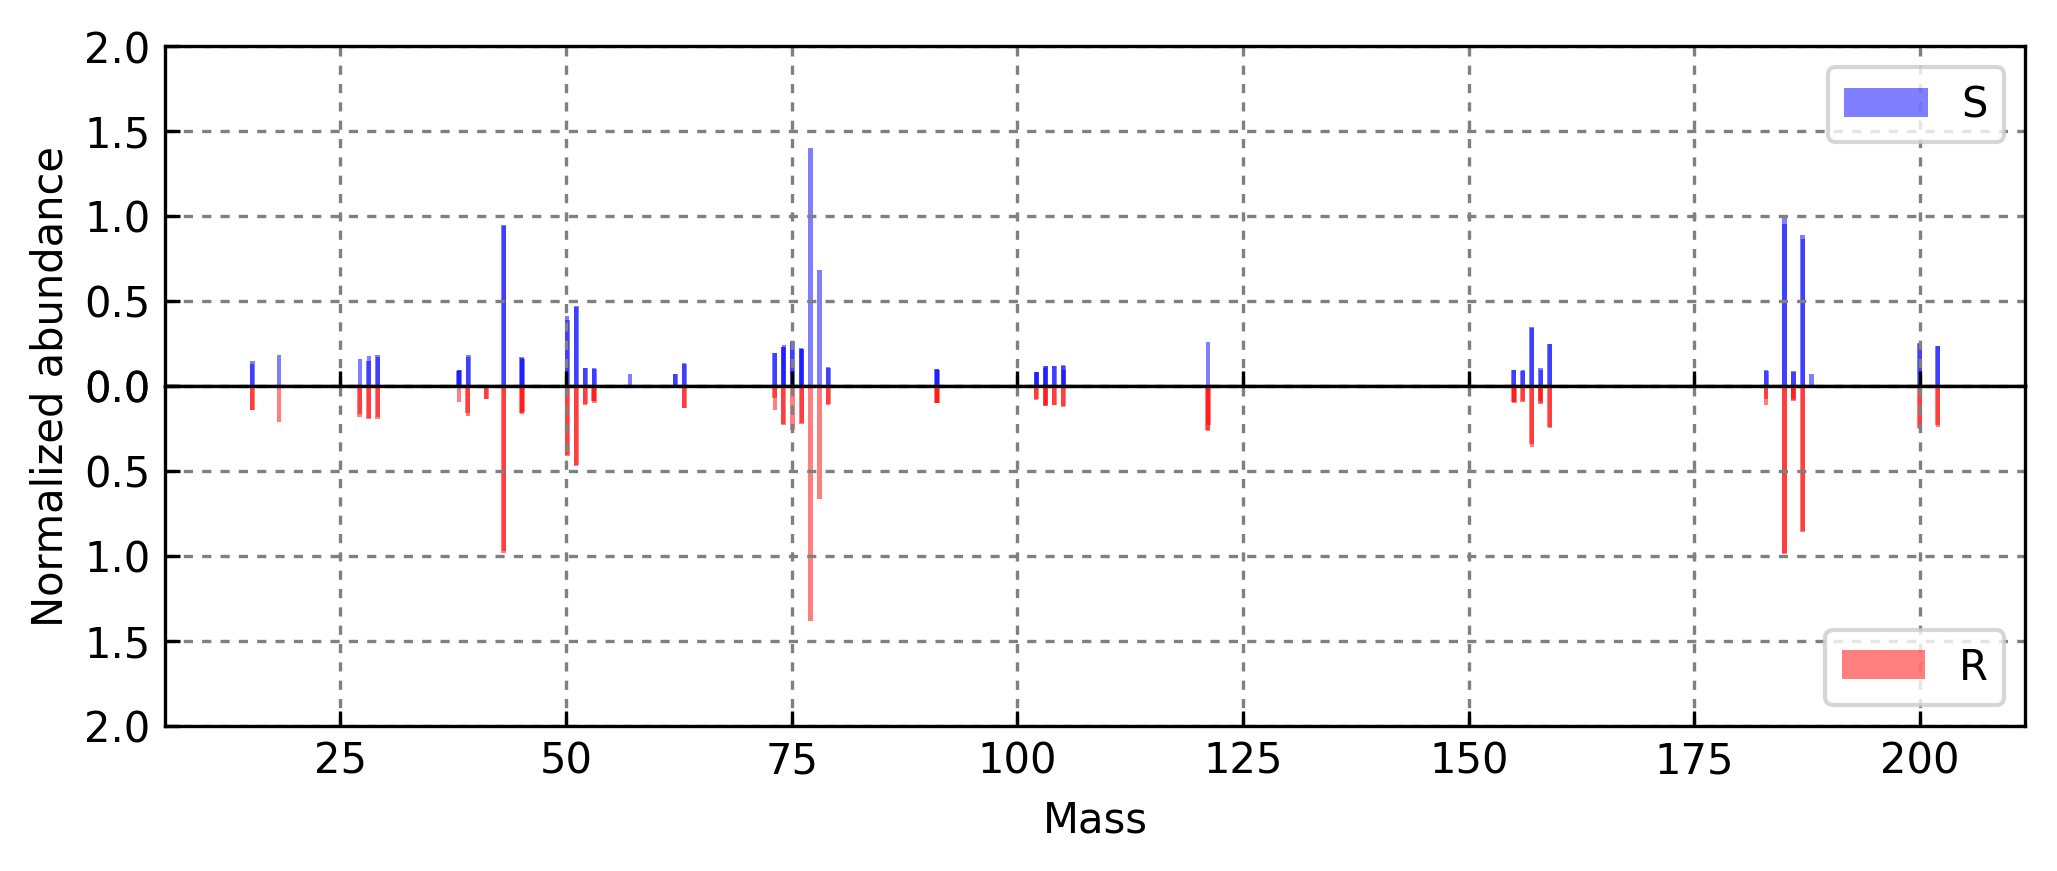

In [37]:
plot_twin_bar((df_s_77.index, df_s_77['avg']), (df_r_77.index, df_r_77['avg']), width = 0.5, 
             title = '')

** Scatter plot with errorbars **

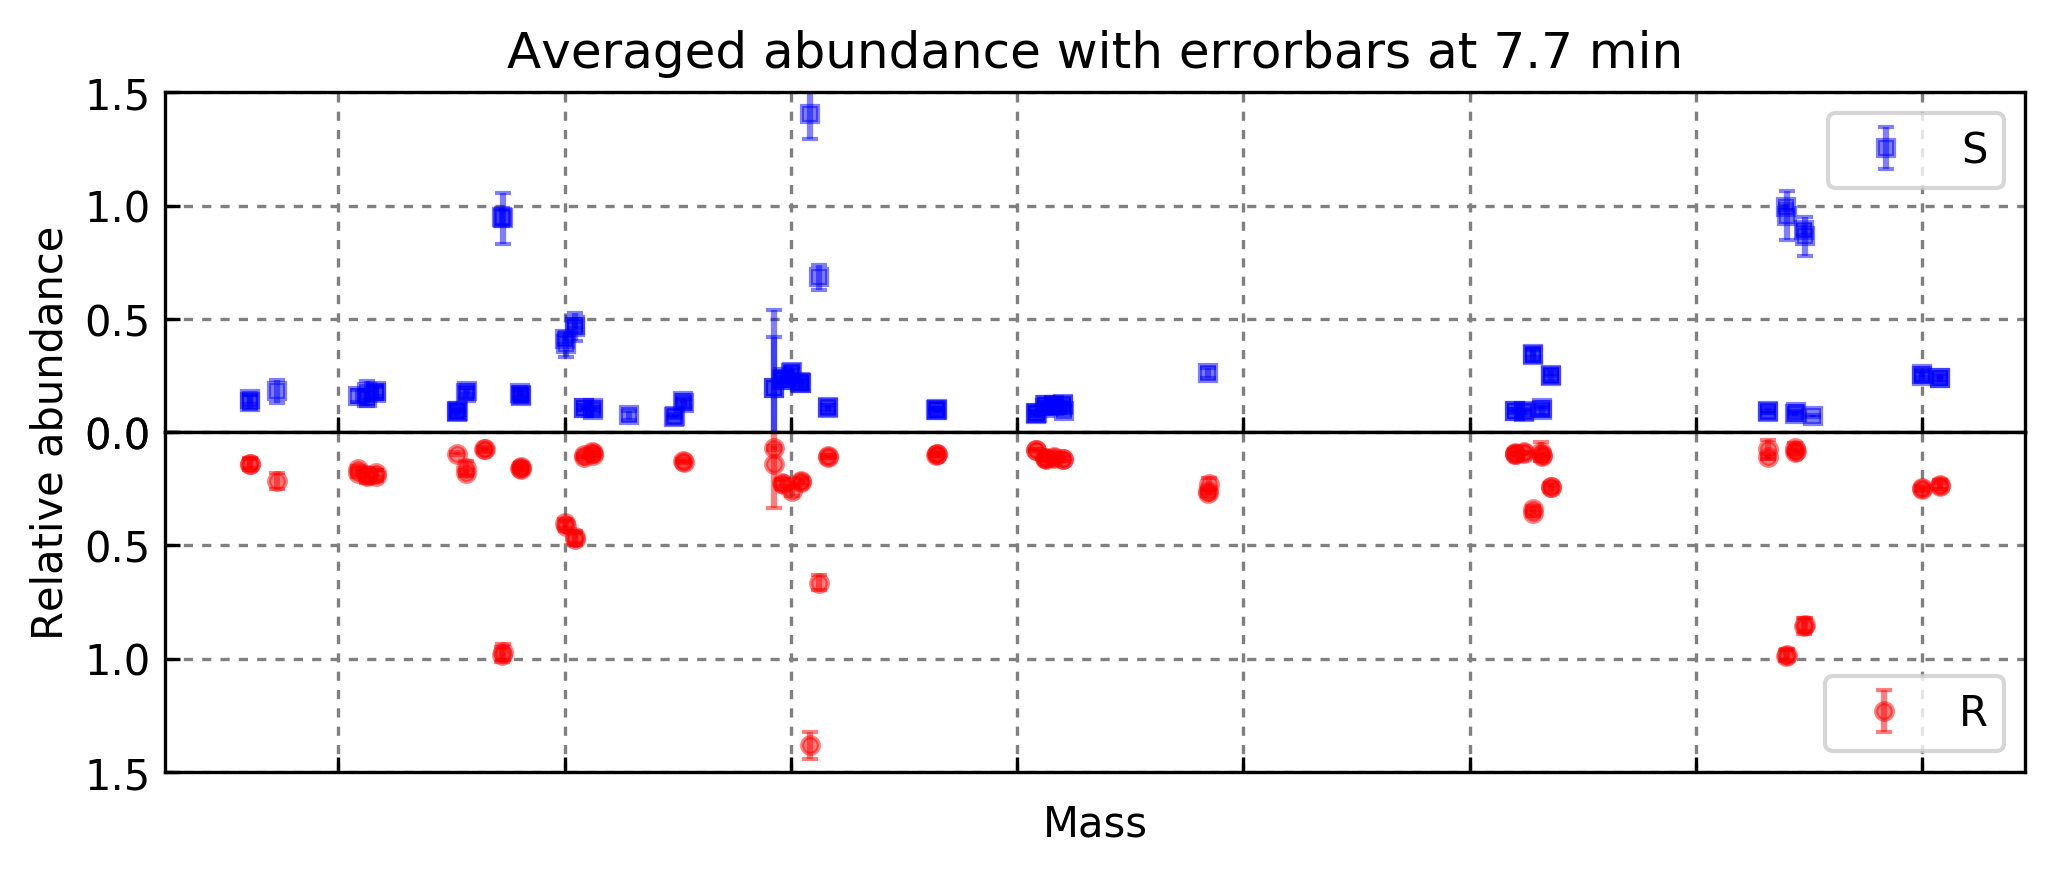

In [18]:
plot_twin_error(df_s_77, df_r_77)

## Use 2 sample t test to find significantly different peaks ##

** Combine the two data frames for further analysis**

** Note that some of the peaks only presented in one compound,**

**here we first analyse the peaks that presented in both compounds**

In [19]:
df_both = pd.concat([df_s_77, df_r_77], axis = 1, join = 'outer')
df_both.columns = ['avg_s', 'std_s', 'cnt_s', 'avg_r', 'std_r', 'cnt_r']

df_single = df_both[df_both['avg_s'].isnull() | df_both['avg_r'].isnull()]
df_single.head()

,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r
27.15,NaN,NaN,NaN,0.180898,0.016119,3.0
38.10,0.087872,0.016473,4.0,NaN,NaN,NaN
38.20,0.092852,0.005991,3.0,NaN,NaN,NaN
39.10,NaN,NaN,NaN,0.160887,0.033272,2.0
39.20,0.182405,0.013315,5.0,NaN,NaN,NaN


In [20]:
df_both

,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r
15.20,0.131196,0.030254,12.0,0.139490,0.018469,6.0
15.25,0.144450,0.019027,6.0,0.141279,0.026854,12.0
18.20,0.180048,0.050985,16.0,0.214591,0.035335,17.0
27.15,NaN,NaN,NaN,0.180898,0.016119,3.0
27.20,0.160526,0.025928,17.0,0.164152,0.015678,15.0
28.15,0.147974,0.035020,9.0,0.193777,0.033244,8.0
28.20,0.177095,0.049772,9.0,0.190791,0.017959,10.0
29.15,0.181356,0.021600,6.0,0.192192,0.023129,8.0
29.20,0.172149,0.024770,11.0,0.182438,0.016853,9.0
38.10,0.087872,0.016473,4.0,NaN,NaN,NaN


In [21]:
df_both = df_both.dropna(axis = 0, how = 'any')
df_both.head()

,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r
15.20,0.131196,0.030254,12.0,0.139490,0.018469,6.0
15.25,0.144450,0.019027,6.0,0.141279,0.026854,12.0
18.20,0.180048,0.050985,16.0,0.214591,0.035335,17.0
27.20,0.160526,0.025928,17.0,0.164152,0.015678,15.0
28.15,0.147974,0.035020,9.0,0.193777,0.033244,8.0


** Calculate the T value between S and R for each mass **

$$ T = \frac{\overline{S}-\overline{R}}{\sqrt{\frac{s_s^2}{N_S}+\frac{s_R^2}{N_R}}} $$

In [22]:
df_both['T'] = abs((df_both['avg_s']-df_both['avg_r'])/np.sqrt(df_both['std_s']**2/df_both['cnt_s']+\
                                                           df_both['std_r']**2/df_both['cnt_r']))
df_both.sort_values('T', ascending = False).head(10)

/Users/yuzhang/programs/anaconda/envs/py3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r,T
182.95,0.092979,0.010890,14.0,0.109389,0.010732,12.0,3.860358
186.00,0.086939,0.002566,7.0,0.082598,0.001957,7.0,3.558516
158.95,0.249833,0.004603,8.0,0.241757,0.007464,11.0,2.907814
28.15,0.147974,0.035020,9.0,0.193777,0.033244,8.0,2.764947
18.20,0.180048,0.050985,16.0,0.214591,0.035335,17.0,2.248949
186.95,0.890129,0.022331,9.0,0.856760,0.034297,7.0,2.232372
157.00,0.340063,0.027517,13.0,0.357786,0.011245,7.0,2.028751
103.10,0.120564,0.007019,11.0,0.113892,0.009071,12.0,1.981588
63.10,0.136494,0.009714,10.0,0.129032,0.009113,11.0,1.810488
53.10,0.103777,0.006379,7.0,0.091083,0.013172,4.0,1.809875


** Calculate the degree of freedom **
$$ D.F = \frac{(\frac{s_s^2}{N_S}+\frac{s_R^2}{N_R})^2}{\frac{(\frac{s_s^2}{N_S})^2}{N_S-1}+\frac{(\frac{s_R^2}{N_R})^2}{N_R-1}}$$

In [23]:
df_both['DF'] = (df_both['std_s']**2/df_both['cnt_s']+df_both['std_r']**2/df_both['cnt_r'])**2/\
                ((df_both['std_s']**2/df_both['cnt_s'])**2/(df_both['cnt_s']-1)+\
                 (df_both['std_r']**2/df_both['cnt_r'])**2/(df_both['cnt_r']-1))
df_both.head()

/Users/yuzhang/programs/anaconda/envs/py3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r,T,DF
15.20,0.131196,0.030254,12.0,0.139490,0.018469,6.0,0.718824,15.079093
15.25,0.144450,0.019027,6.0,0.141279,0.026854,12.0,0.289003,13.728988
18.20,0.180048,0.050985,16.0,0.214591,0.035335,17.0,2.248949,26.541912
27.20,0.160526,0.025928,17.0,0.164152,0.015678,15.0,0.484834,26.757230
28.15,0.147974,0.035020,9.0,0.193777,0.033244,8.0,2.764947,14.918992


In [24]:
alpha = 0.05
df_both['Critical'] = stats.t.ppf(1-alpha/2, df_both['DF'])

/Users/yuzhang/programs/anaconda/envs/py3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [25]:
df_sign = df_both[df_both['T'] > df_both['Critical']].iloc[:, :6]
df_sign

,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r
18.20,0.180048,0.050985,16.0,0.214591,0.035335,17.0
28.15,0.147974,0.035020,9.0,0.193777,0.033244,8.0
158.95,0.249833,0.004603,8.0,0.241757,0.007464,11.0
182.95,0.092979,0.010890,14.0,0.109389,0.010732,12.0
186.00,0.086939,0.002566,7.0,0.082598,0.001957,7.0


In [26]:
df_sign.sort_values('avg_s', ascending = False)

,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r
158.95,0.249833,0.004603,8.0,0.241757,0.007464,11.0
18.20,0.180048,0.050985,16.0,0.214591,0.035335,17.0
28.15,0.147974,0.035020,9.0,0.193777,0.033244,8.0
182.95,0.092979,0.010890,14.0,0.109389,0.010732,12.0
186.00,0.086939,0.002566,7.0,0.082598,0.001957,7.0


** Calculate the relative change between R and S **

In [27]:
df_sign['c2s'] = abs(df_sign['avg_s']-df_sign['avg_r'])/df_sign['avg_s']
df_sign['c2r'] = abs(df_sign['avg_s']-df_sign['avg_r'])/df_sign['avg_r']

** Top 10 masses whose peak changed most relative to S **

In [28]:
df_sign.sort_values('c2s', ascending = False).head(10)

,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r,c2s,c2r
28.15,0.147974,0.035020,9.0,0.193777,0.033244,8.0,0.309532,0.236368
18.20,0.180048,0.050985,16.0,0.214591,0.035335,17.0,0.191853,0.160970
182.95,0.092979,0.010890,14.0,0.109389,0.010732,12.0,0.176486,0.150011
186.00,0.086939,0.002566,7.0,0.082598,0.001957,7.0,0.049928,0.052552
158.95,0.249833,0.004603,8.0,0.241757,0.007464,11.0,0.032326,0.033406


In [38]:
df_sign

,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r,c2s,c2r
18.20,0.180048,0.050985,16.0,0.214591,0.035335,17.0,0.191853,0.160970
28.15,0.147974,0.035020,9.0,0.193777,0.033244,8.0,0.309532,0.236368
158.95,0.249833,0.004603,8.0,0.241757,0.007464,11.0,0.032326,0.033406
182.95,0.092979,0.010890,14.0,0.109389,0.010732,12.0,0.176486,0.150011
186.00,0.086939,0.002566,7.0,0.082598,0.001957,7.0,0.049928,0.052552


** Top 10 masses whose peak changed most relative to R **

In [29]:
df_sign.sort_values('c2s', ascending = False).head(10)

,avg_s,std_s,cnt_s,avg_r,std_r,cnt_r,c2s,c2r
28.15,0.147974,0.035020,9.0,0.193777,0.033244,8.0,0.309532,0.236368
18.20,0.180048,0.050985,16.0,0.214591,0.035335,17.0,0.191853,0.160970
182.95,0.092979,0.010890,14.0,0.109389,0.010732,12.0,0.176486,0.150011
186.00,0.086939,0.002566,7.0,0.082598,0.001957,7.0,0.049928,0.052552
158.95,0.249833,0.004603,8.0,0.241757,0.007464,11.0,0.032326,0.033406


- Indicated by average abundance, frequency of appearance and change ratio, peaks at **28.15** and **18.20** changed significantly between R and S

## Look into the peaks that only belong to one compound ##

** Peaks only shown in S, sorted by their appearance **

In [30]:
df_single.iloc[:, :3].dropna().sort_values('cnt_s', ascending = False)

,avg_s,std_s,cnt_s
62.10,0.068129,0.007912,12.0
187.95,0.070035,0.003935,11.0
39.20,0.182405,0.013315,5.0
38.10,0.087872,0.016473,4.0
62.15,0.072696,0.006766,4.0
38.20,0.092852,0.005991,3.0
57.10,0.072891,0.020089,2.0
74.15,0.241740,0.022617,2.0
75.05,0.259808,0.013454,2.0
76.05,0.221533,0.007547,2.0


** Sort by the average abundance of S**

In [31]:
df_single.iloc[:, :3].dropna().sort_values('avg_s', ascending = False)

,avg_s,std_s,cnt_s
75.05,0.259808,0.013454,2.0
74.15,0.241740,0.022617,2.0
76.05,0.221533,0.007547,2.0
39.20,0.182405,0.013315,5.0
105.15,0.094833,0.021926,2.0
38.20,0.092852,0.005991,3.0
183.00,0.088092,0.005717,2.0
38.10,0.087872,0.016473,4.0
102.15,0.085150,0.001742,2.0
57.10,0.072891,0.020089,2.0


** Sort by the appearance of R**

In [32]:
df_single.iloc[:, 3:].dropna().sort_values('cnt_r', ascending = False)

,avg_r,std_r,cnt_r
41.15,0.077051,0.011414,15.0
182.90,0.077113,0.041945,5.0
185.90,0.072103,0.023397,5.0
27.15,0.180898,0.016119,3.0
41.20,0.077254,0.006009,3.0
155.05,0.098404,0.003750,3.0
39.10,0.160887,0.033272,2.0
53.05,0.089290,0.001279,2.0
121.05,0.259608,0.008742,2.0
121.15,0.228682,0.025254,2.0


** Sort by the average value of R **

In [33]:
df_single.iloc[:, 3:].dropna().sort_values('avg_r', ascending = False)

,avg_r,std_r,cnt_r
121.05,0.259608,0.008742,2.0
121.15,0.228682,0.025254,2.0
27.15,0.180898,0.016119,3.0
39.10,0.160887,0.033272,2.0
155.05,0.098404,0.003750,3.0
53.05,0.089290,0.001279,2.0
157.90,0.086184,0.042305,2.0
41.20,0.077254,0.006009,3.0
182.90,0.077113,0.041945,5.0
41.15,0.077051,0.011414,15.0
